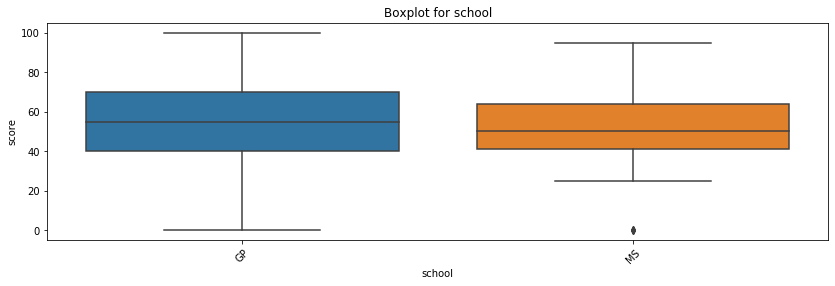

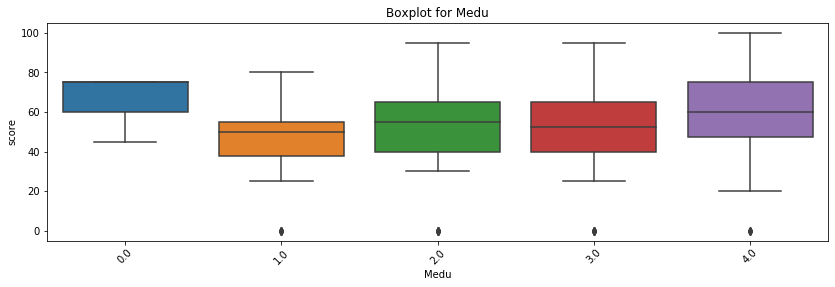

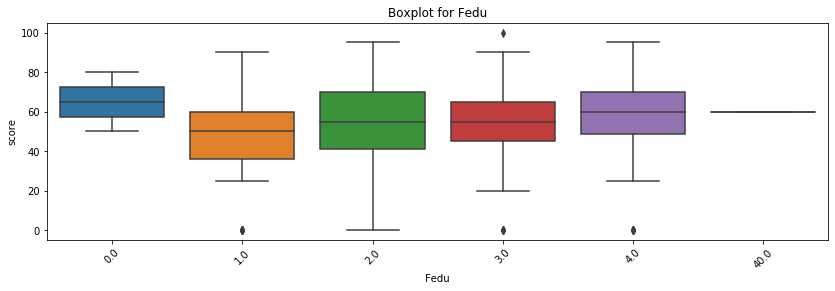

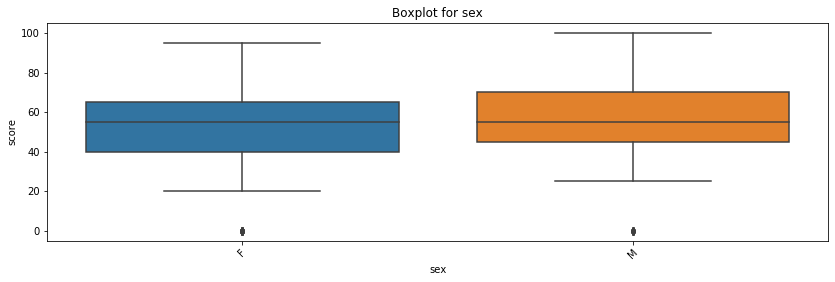

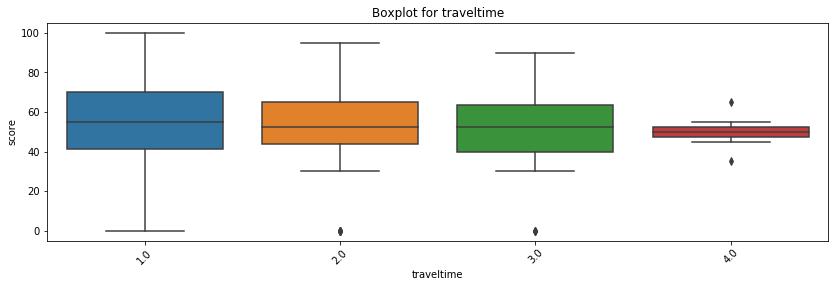

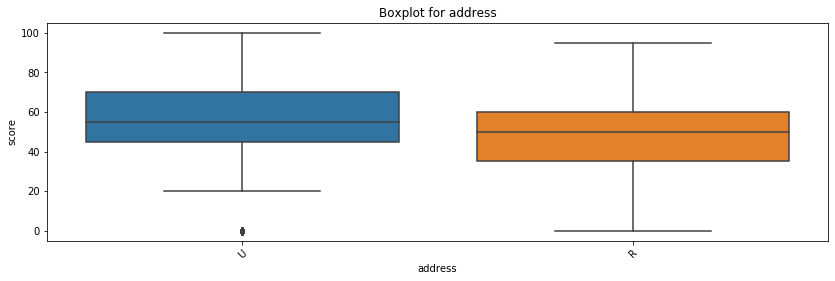

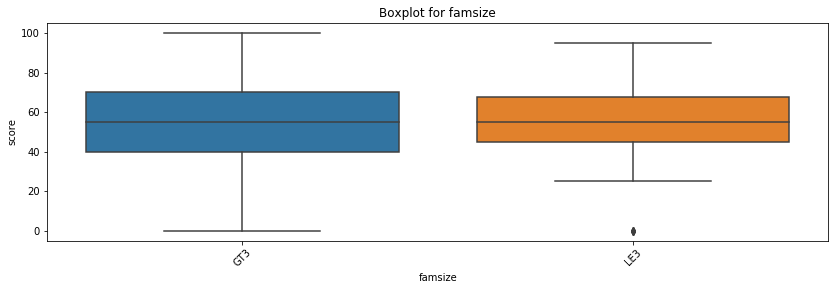

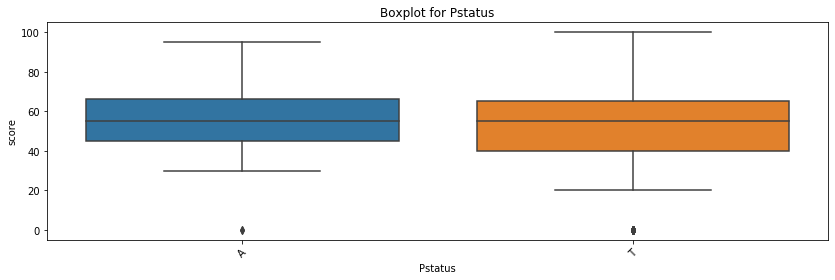

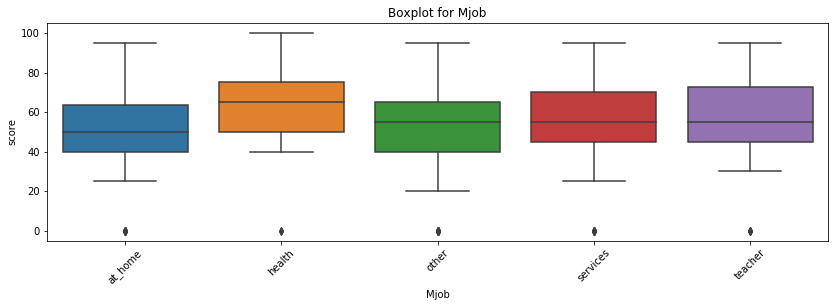

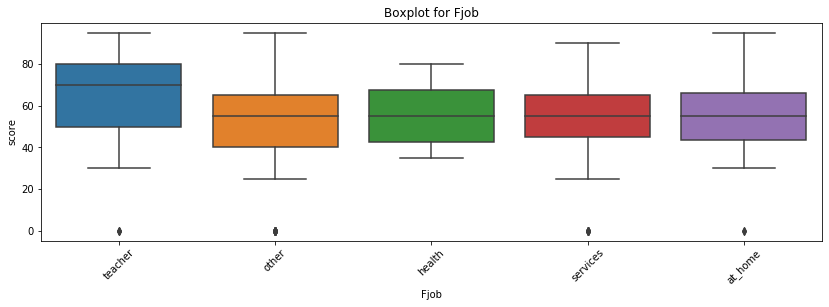

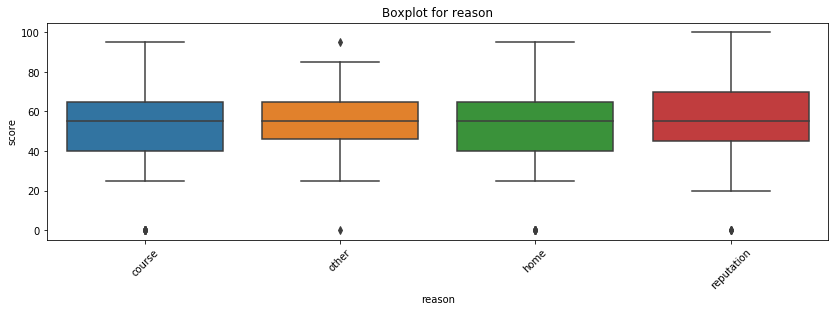

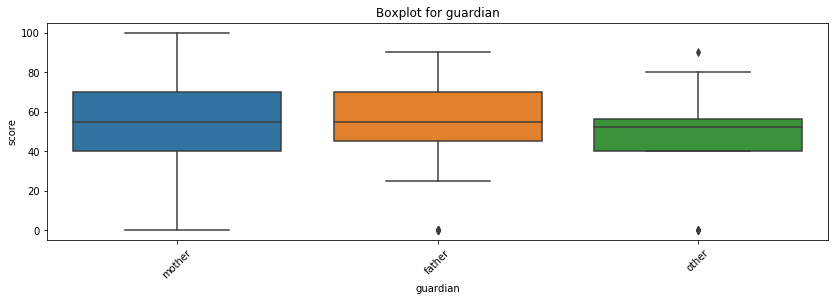

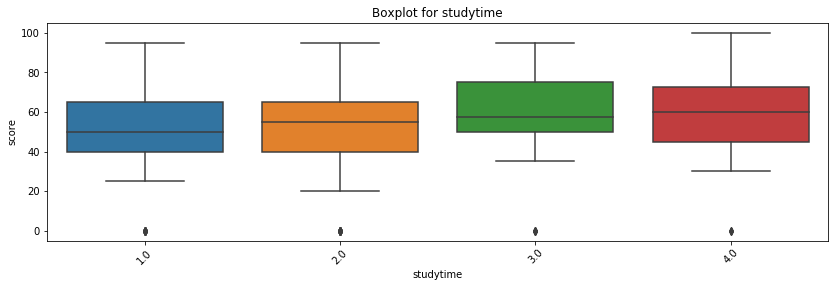

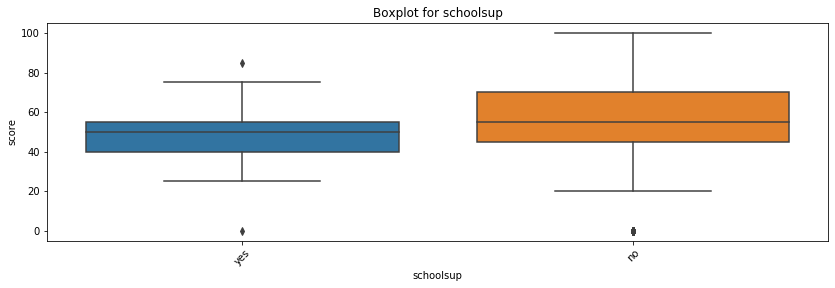

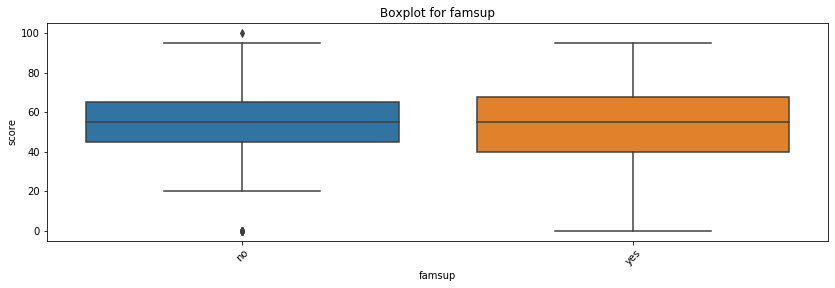

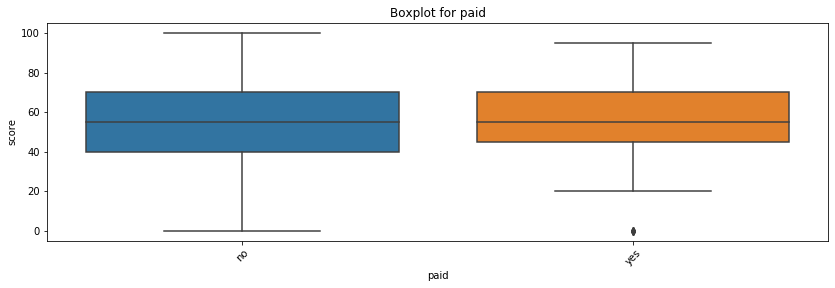

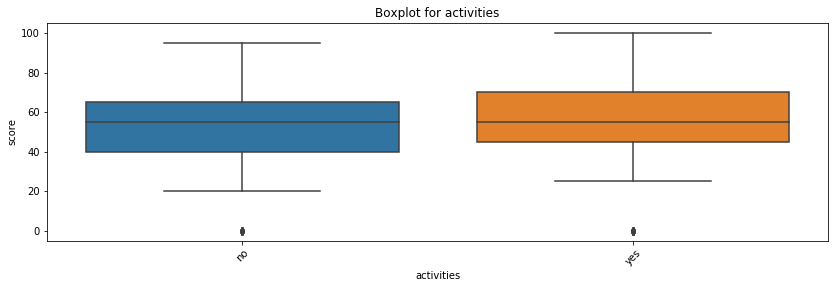

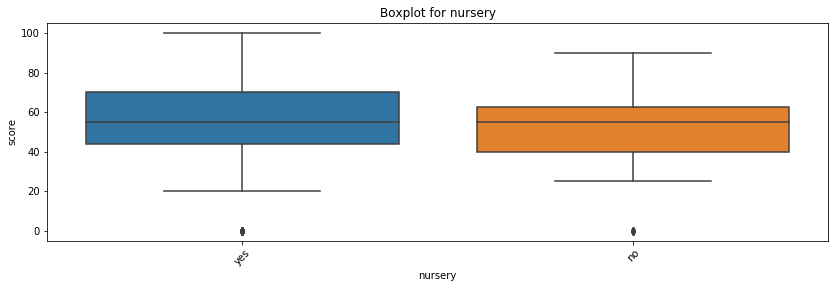

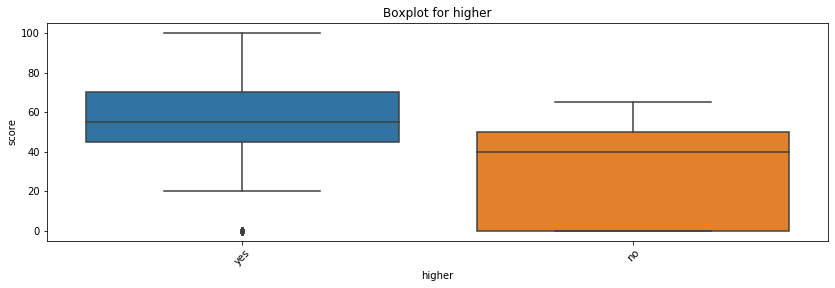

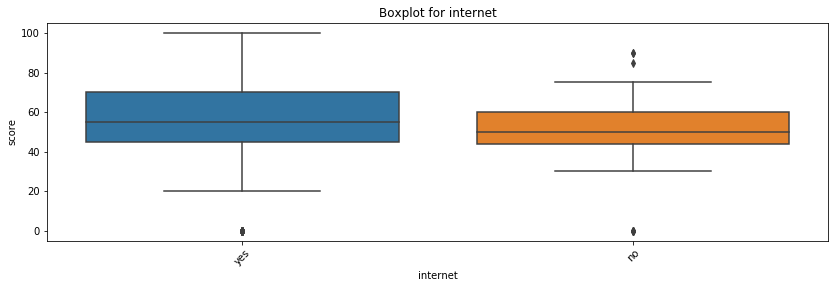

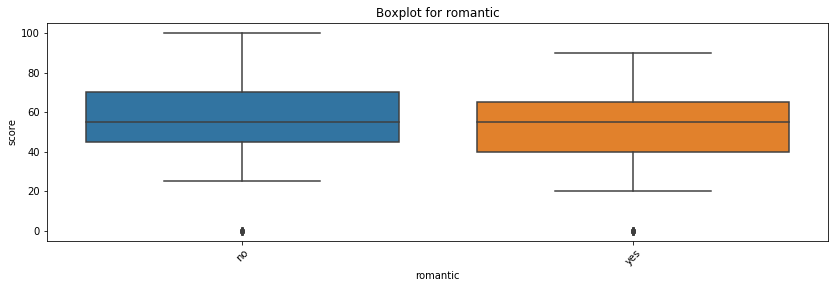

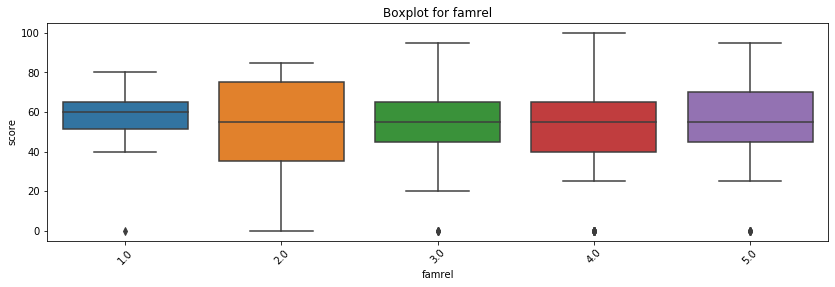

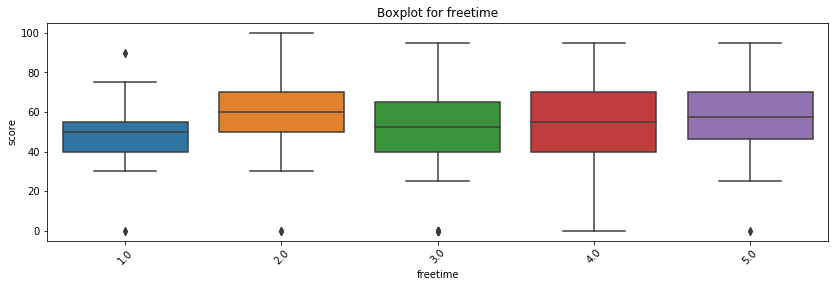

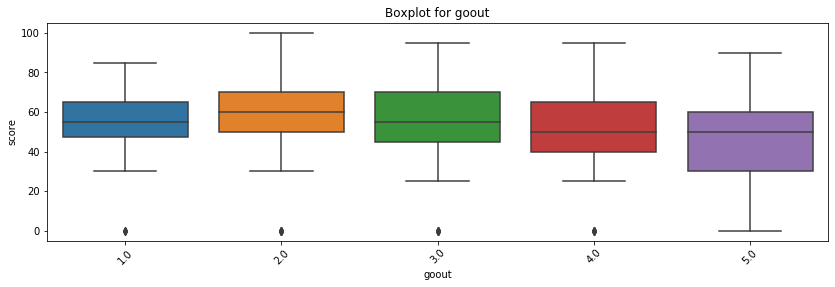

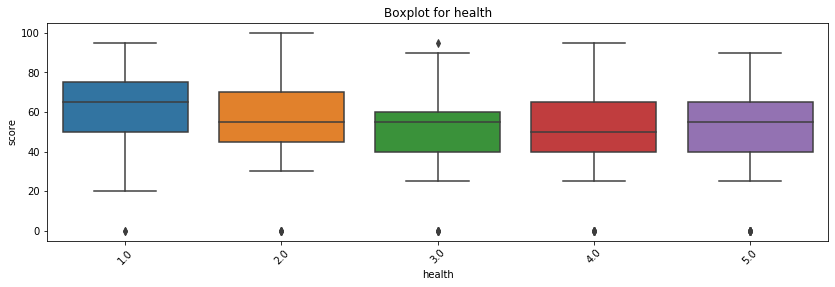

Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


In [78]:
com = '''Цели и задачи проекта.
Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.
Целью отчетного этапа проекта является подготовка с помощью разведывательного анализа данных  предложенного датасета  к построению предсказательной и рекомендательной модели.
Данный этап проекта предполагает решение следующих задач:
-	первичная обработка данных;
-	устранение выбросов;
-	анализ номиативных и количественных переменных;
-	проведение корреляционного анализа для номиативных и количественных переменных;
-	устранение данных не влияющих на предсказываемую величину.
'''

import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import collections 
import warnings; warnings.simplefilter('ignore')


from collections import Counter
from itertools import combinations
from scipy.stats import ttest_ind

stud_math = pd.read_csv('stud_math.csv')


#1.Первичная обработка данных.

#смотрим типы столбцов
#stud_math.info()

#для удобства переименовываем столбец 'studytime, granular'
stud_math.rename(columns={'studytime, granular': 'studytime_g'},inplace=True)

#для начала анализируем числовые показатели датасета
#stud_math.describe()

#считаем количество пропусков по столбцам
#stud_math.isna().sum()


#видим "выбросы" в столбце absences, Fedu, под вопросом age   
# убираем отрицательные значения в столбце famrel, так как по условиям задачи данные столбцы содержат положительные величины 
stud_math.famrel = stud_math.famrel.apply(lambda x: math.fabs(x))
#display(stud_math_categor.famrel.sort_values()[:10])

#удаляем столбец failures в виду большого количества нулей
stud_math.drop(['failures'], inplace = True, axis = 1)

#Для удобства формируем новый датасет из столбцов с количественными и категориальными признаками для удаения выбросов

stud_math_numeric = stud_math[['age','absences','Fedu','score']]

#Для удобства формируем новый датасет из столбцов с  категориальными признаками для построения графики
stud_math_categor = stud_math[['school','Medu','Fedu','sex', 'traveltime','address','famsize','Pstatus','Mjob','Fjob','reason', 'guardian', 'studytime','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic','famrel','freetime','goout','health']]

#для категориальных не числовых признаков описываем функции меняющие Nan/nan на None 
def add_none_up(x):
    x = x.astype(str).apply(lambda y: 'None' if pd.isnull(y) else 'None' if y == 'NaN' 
                      else y if '(' not in y else x[:y.find('(')].strip())
    return x

def add_none_low(x):
    x = x.astype(str).apply(lambda y: 'None' if pd.isnull(y) else 'None' if y == 'nan' 
                      else y if '(' not in y else x[:y.find('(')].strip())
    return x

#поизводим замену Nan|nan Ha None
stud_math_categor = stud_math_categor.apply(lambda x: add_none_up(x))
stud_math_categor = stud_math_categor.apply(lambda x: add_none_low(x))

#анализируем номиативные столбцы для принятия решений по замене пропусков
#посмотрим на нулевые значения и пропуски по столбцам
#заменим пропуски для числовых столбцов на медиану 
stud_math = stud_math.fillna(stud_math.median())

#для номиативных переменных пустые значения возможно менять с учетом корреляций с другими столбцами, например Pststus c Traveltime и Mjob

#Выводы: пострели типы переменных, выявили количество пропусков и нулевых значений, поризвели частичную замену пропусков

#2.устраняем выбросы
#Описываем функцию по устранению выбросов
def cut_emissions(x):
    median = x.median()
    IQR = x.quantile(0.75) - x.quantile(0.25)
    perc25 = x.quantile(0.25)
    perc75 = x.quantile(0.75)
    x = x.loc[x.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)]
    return x

#применяем функцию по удлаению выбросов последовательно к каждому числовому столбцу датафрейма,
#предварительно строим гистограммы по каждому столбцу, что бы избежать удаления информативных данных
#пример построения гистограммы приведен для одного столба(что бы не нагружать код)

#пример построения гистограммы для столбца age, для переменной score анализ показал отсутствие выбросов 
#median = stud_math.age.median()
#IQR = stud_math.age.quantile(0.75) - stud_math.age.quantile(0.25)
#perc25 = stud_math.age.quantile(0.25)
#perc75 = stud_math.age.quantile(0.75)

#print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
#      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
#stud_math.age.loc[stud_math.age.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 16, range = (0, 25), label = 'IQR')

#stud_math.age.loc[stud_math.age <= 100].hist(alpha = 0.5, bins = 16, range = (0, 25),label = 'Здравый смысл')
#plt.legend();

# применяем функцию по устранению выбросов
stud_math_numeric = stud_math_numeric.apply(lambda x: cut_emissions(x)) 

#Выводы: в реузльтате проделанной работы мы удалили выбросы в признаке 'Age','absences','Fedu' 

#3.Оценим количество уникальных значений для номинативных переменных.
#построим соответствующие гистограммы 
com1 = '''fig, axes = plt.subplots(1,4, figsize = (18,5))
axes[0].hist(stud_math_categor['Pstatus'])
axes[0].set_title('ЧР признака Pstatus') 

axes[1].hist(stud_math_categor['Fedu'])
axes[1].set_title('ЧР признака Fedu') 

axes[2].hist(stud_math_categor['Medu'])
axes[2].set_title('ЧР признака Medu') 

axes[3].hist(stud_math_categor['Fjob'])
axes[3].set_title('ЧР признака Fjob') 

fig1, axes1 = plt.subplots(1,4, figsize = (18,5))
axes1[0].hist(stud_math_categor['Mjob'])
axes1[0].set_title('ЧР признака Mjob') 

axes1[1].hist(stud_math_categor['sex'])
axes1[1].set_title('ЧР признака sex') 

axes1[2].hist(stud_math_categor['address'])
axes1[2].set_title('ЧР признака address') 

axes1[3].hist(stud_math_categor['famsize'])
axes1[3].set_title('ЧР признака famsize') 

fig2, axes2= plt.subplots(1,4, figsize = (18,5))
axes2[0].hist(stud_math_categor['reason'])
axes2[0].set_title('ЧР признака reason') 

axes2[1].hist(stud_math_categor['guardian'])
axes2[1].set_title('ЧР признака guardian ') 

axes2[2].hist(stud_math_categor['traveltime'])
axes2[2].set_title('ЧР признака traveltime ') 

axes2[3].hist(stud_math_categor['studytime'])
axes2[3].set_title('ЧР признака studytime ')

fig3, axes3= plt.subplots(1,4, figsize = (18,5))
axes3[0].hist(stud_math_categor['schoolsup'])
axes3[0].set_title('ЧР признака schoolsup ') 

axes3[1].hist(stud_math_categor['famsup'])
axes3[1].set_title('ЧР признака famsup') 

axes3[2].hist(stud_math_categor['paid'])
axes3[2].set_title('ЧР признака paid ') 

axes3[3].hist(stud_math_categor['activities'])
axes3[3].set_title('ЧР признака activities')

fig4, axes4= plt.subplots(1,4, figsize = (18,5))
axes4[0].hist(stud_math_categor['nursery'])
axes4[0].set_title('ЧР признака nursery ') 

axes4[1].hist(stud_math_categor['higher'])
axes4[1].set_title('ЧР признака higher') 

axes4[2].hist(stud_math_categor['internet'])
axes4[2].set_title('ЧР признака internet') 

axes4[3].hist(stud_math_categor['romantic'])
axes4[3].set_title('ЧР признака romantic')

fig5, axes5= plt.subplots(1,4, figsize = (18,5))
axes5[0].hist(stud_math_categor['famrel'])
axes5[0].set_title('ЧР признака famrel  ') 

axes5[1].hist(stud_math_categor['freetime'])
axes5[1].set_title('ЧР признака freetime') 

axes5[2].hist(stud_math_categor['goout'])
axes5[2].set_title('ЧР признака goout ') 

axes5[3].hist(stud_math_categor['health'])
axes5[3].set_title('ЧР признака health ')'''
# Выводы: 
# по результатам просмотра распределение опеределим данные со значимыми(разница между значениями более чем 2 раза) разрывами по значениям:
# pstatus fjob adress famsize guardian traveltime studytime schoolsup nursery higner internet romantic
# возможно при построении boxplot имеет смысл использовать указанные столбцы в качестве признака дополнительного распределения 

#5, 6Коррелиационный анализ 
#Проведем аналих для числовых переменных
#строим графики зависимости переменных 
#sns.pairplot(stud_math_numeric, vars=['age','score','absences'])
#строим матрицу корелляций
#display(stud_math_numeric.corr())
#Выводы:
# полученные данные повзоялют предположить, что между числовыми 
#признаками корреляция отсутствует(есть очень слабая корреляция между score и absences, что кажется не логичным корреляция могла бы быть и выше)
# с age наблюдается отрицательная корреляция, данный столбец для анализа можно не использовать

#7.Анализ номиатынх переменных
#Проанализируем номинативные переменные и устраним те, которые не влияют на предсказываемую величину
# перейдем к графическому анализу номиативных переменных с использованием boxplot
# опишем функцию отображения сначала строим без параметра hue 
# далее для анализа изменения корреляции со score  в качечтве параметра hue перебираем наименование столбцов определенных в п.3
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=stud_math.loc[stud_math.loc[:, column].isin(stud_math.loc[:, column])],#hue ='health',
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
#отобразим данные
for col in ['school','Medu','Fedu','sex', 'traveltime','address','famsize','Pstatus','Mjob','Fjob','reason', 'guardian', 'studytime','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic','famrel','freetime','goout','health']:
    get_boxplot(col)

#визуальный анализ позволяет нам сделать вывод о возможной корреляции номинативных переменных со score 
# проведенный анализ boxplot в виде табличной части приведен в файле "краткое описание проекта.docx"


#далее попробуем определить статистически значимые перменные с помощью теста Стьюдента
#опишем функцию для проверки нулевой гипотезы
stud_math[['age','absences','Fedu']] = stud_math_numeric[['age','absences','Fedu']]

def get_stat_dif(column):
    c = stud_math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(c, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'], 
                        stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

for col in ['school','Medu','Fedu','sex', 'traveltime','address','famsize','Pstatus','Mjob','Fjob','reason', 'guardian', 'studytime','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic','famrel','freetime','goout','health']:
    get_stat_dif(col) 

#Найдены статистически значимые различия для колонки Medu,address,Mjob,higher,romantic
#Таким образом мы выявили пять параметров, изменение значений которых могцут влиять на score. 
#Оставим данные параметры для дальнейшего анализа


#Выводы
com3 = '''
Анализ графики Boxplot с использованием сегментации раскрывает очевидные тенденции к усилению корреляцию в ряде случаев.
Таким образом оценка данной графики позволяет с уверенностью говорить о корреляции со score следующих признаков:
Medu, Fedu, Mjob, Fjob, studytime, Guardian, studytime, freetime, Higher, famrel , freetime , goout, health, romantic, Pstatus. 
Тест Стьюдента так же добавляет к этим переменных, переменную 'address'/

Признаки не вошедшие в указанный список предлагается исключить из дальнейшего анализа.  


'''
